# **1D-CNN AE 모델 구현 코드 (1차 수정, ver2)**

훈련 설정
- 학습셋: 정상 데이터만 사용
- 테스트셋: 불량 데이터만 사용

전처리 방법
- 모든 Wafer_ID의 Time step을 100으로 고정시키도록 보간법 적용
- MinMax Scaling 적용



## **1. 드라이브 연결**

In [13]:
from google.colab import drive
import os


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. 파라미터 설정 및 데이터 로드**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. 파라미터 설정 및 데이터 로드
# ==========================================
FIXED_LENGTH = 100      # 시계열 길이 통일 (논문/모델 입력 사이즈)
EPOCHS = 100            # 학습 에폭 수
BATCH_SIZE = 16         # 배치 사이즈 (노트북 설정 유지)
SENSOR_COLS = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"
if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    print(f"Data loaded: {df.shape}")
else:
    raise FileNotFoundError(f"{file_path} 파일을 찾을 수 없습니다.")


Data loaded: (12829, 25)


## **3. 함수 정의**

In [15]:
# ==========================================
# 2. 함수 정의 (전처리 & LRE & 점수계산)
# ==========================================
def preprocess_wafer_data(df_subset, sensor_cols, target_len):
    wafer_ids = df_subset['Wafer_ID'].unique()
    data_list, label_list = [], []

    print(f"총 웨이퍼 수: {len(wafer_ids)}")

    for wid in wafer_ids:
        wafer_df = df_subset[df_subset['Wafer_ID'] == wid]
        if 'Label' not in wafer_df.columns: continue

        # 라벨링 저장
        label = 0 if wafer_df['Label'].iloc[0] == 'Normal' else 1
        sensor_data = wafer_df[sensor_cols].values

        if len(sensor_data) == 0: continue

        # 보간법
        x_old = np.linspace(0, 1, len(sensor_data))
        x_new = np.linspace(0, 1, target_len)
        f = interp1d(x_old, sensor_data, axis=0, kind='linear')

        data_list.append(f(x_new))
        label_list.append(label)

    return np.array(data_list), np.array(label_list)

def calculate_lre(model, data):
    """
    Localized Reconstruction Error 계산
    Returns: (Samples, Sensors) 형태의 센서별 평균 오차
    """
    recon = model.predict(data, verbose=0)
    abs_error = np.abs(data - recon)
    # 시간축(Time=100)에 대해서만 평균 -> 센서별 오차 산출
    return np.mean(abs_error, axis=1)

def calculate_anomaly_score(lre_data, mean, std):
    """
    학습 데이터 통계(mean, std)를 이용해 Z-Score 정규화 후
    각 샘플에서 가장 큰 오차(Max)를 이상 점수로 사용
    """
    normalized_error = (lre_data - mean) / std
    return np.max(normalized_error, axis=1)


# ==========================================
# 3. 모델 정의 (Strided 1D-CAE)
# 변경점1: Pooling 대신 Stride=2 사용
# 변경점2: Activation: ReLU
# ==========================================
# 모델 생성 함수(1D-CAE)
def build_strided_cae(input_shape):
    input_layer = Input(shape=input_shape)

    # --- Encoder ---
    # Stride=2로 바꿔서 Pooling 없이 차원 축소
    x = Conv1D(filters=32, kernel_size=7, strides=2, activation='relu', padding='same')(input_layer) # (50, 32)
    x = Conv1D(filters=16, kernel_size=5, strides=2, activation='relu', padding='same')(x) # (25, 16)

    # Bottleneck
    shape_before_flatten = x.shape[1:]
    x = Flatten()(x)
    encoded = Dense(20, activation='relu')(x) # Latent Dimension

    # --- Decoder ---
    x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded)
    x = Reshape(shape_before_flatten)(x)

    # Conv1DTranspose를 사용하여 차원 확대 (Upsampling + Conv 효과)
    x = Conv1DTranspose(filters=16, kernel_size=5, strides=2, activation='relu', padding='same')(x) # (50, 16)
    x = Conv1DTranspose(filters=32, kernel_size=7, strides=2, activation='relu', padding='same')(x) # (100, 32)

    # Output Layer
    decoded = Conv1DTranspose(filters=input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(x)

    return Model(input_layer, decoded)

## **4. 메인 실행**

- 학습 데이터: 정상 데이터 전체
- 테스트 데이터: 불량 데이터 전체


 실험 시작: l29
총 웨이퍼 수: 43

>> [Step 1] 보간법 변환 완료
   - 전체 데이터 형태 (Raw): (43, 100, 19) (Wafer, Time, Sensor)
   - Normal(학습용) 개수: 34
   - Fault(테스트용) 개수: 9

>> [Step 2] 스케일링 준비 (3D -> 2D)
   - 학습 데이터 2D Flatten 형태: (3400, 19)

>> [Step 3] 모델 입력 준비 (2D -> 3D)
   - 최종 학습셋 형태 (X_train): (34, 100, 19)
   - 최종 테스트셋 형태 (X_fault): (9, 100, 19)

>> [Step 4] 모델 학습 시작
   - 학습 완료

>> [Step 5] 결과 요약
   - ROC AUC Score: 0.9346
   - Optimal Threshold: 0.073994


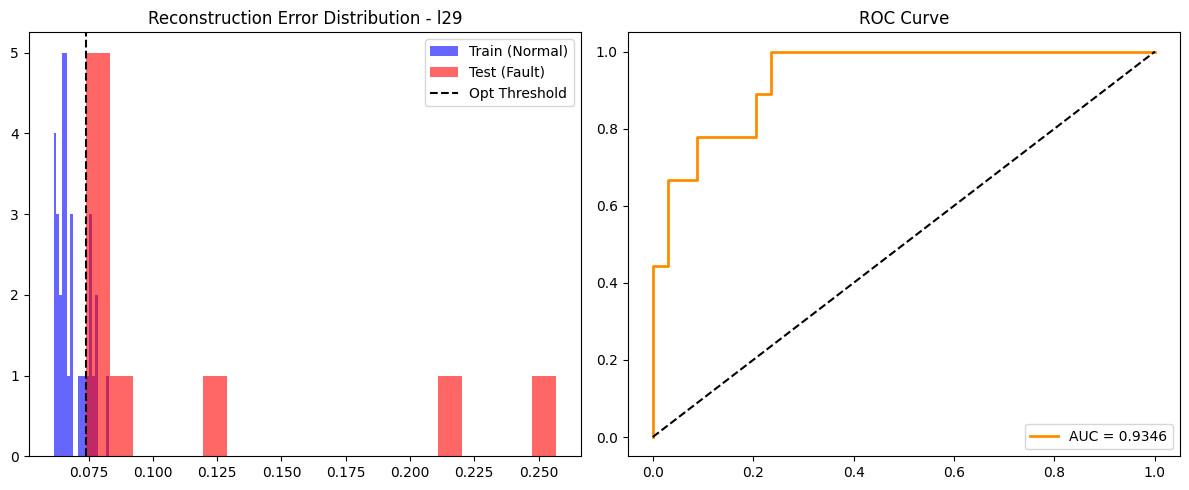


 실험 시작: l31
총 웨이퍼 수: 43

>> [Step 1] 보간법 변환 완료
   - 전체 데이터 형태 (Raw): (43, 100, 19) (Wafer, Time, Sensor)
   - Normal(학습용) 개수: 37
   - Fault(테스트용) 개수: 6

>> [Step 2] 스케일링 준비 (3D -> 2D)
   - 학습 데이터 2D Flatten 형태: (3700, 19)

>> [Step 3] 모델 입력 준비 (2D -> 3D)
   - 최종 학습셋 형태 (X_train): (37, 100, 19)
   - 최종 테스트셋 형태 (X_fault): (6, 100, 19)

>> [Step 4] 모델 학습 시작
   - 학습 완료

>> [Step 5] 결과 요약
   - ROC AUC Score: 0.9505
   - Optimal Threshold: 0.109059


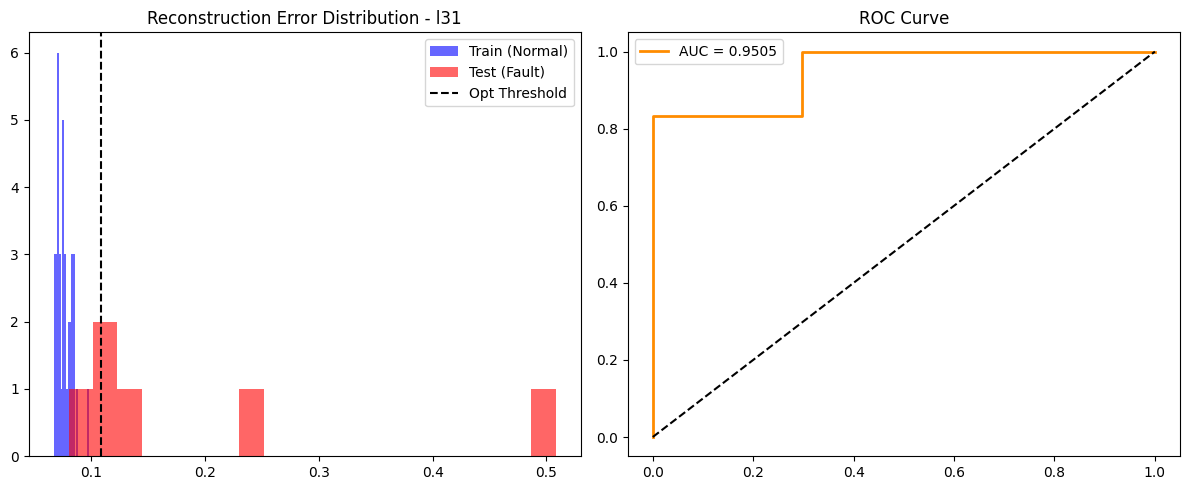


 실험 시작: l33
총 웨이퍼 수: 43

>> [Step 1] 보간법 변환 완료
   - 전체 데이터 형태 (Raw): (43, 100, 19) (Wafer, Time, Sensor)
   - Normal(학습용) 개수: 37
   - Fault(테스트용) 개수: 6

>> [Step 2] 스케일링 준비 (3D -> 2D)
   - 학습 데이터 2D Flatten 형태: (3700, 19)

>> [Step 3] 모델 입력 준비 (2D -> 3D)
   - 최종 학습셋 형태 (X_train): (37, 100, 19)
   - 최종 테스트셋 형태 (X_fault): (6, 100, 19)

>> [Step 4] 모델 학습 시작
   - 학습 완료

>> [Step 5] 결과 요약
   - ROC AUC Score: 0.9955
   - Optimal Threshold: 0.086969


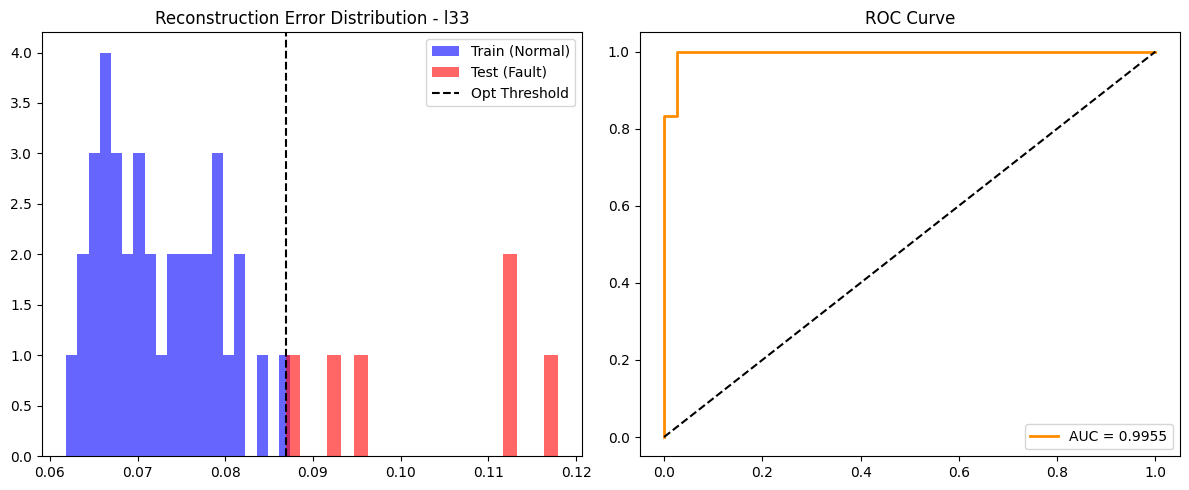


모든 실험 종료.


In [16]:
experiments = ['l29', 'l31', 'l33']

for exp_id in experiments:
    print(f"\n{'='*50}")
    print(f" 실험 시작: {exp_id}")
    print(f"{'='*50}")

    # 1. 데이터 필터링
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
    if exp_df.empty: continue

    # 2. 전처리 (Interpolation)
    X_raw, y_labels = preprocess_wafer_data(exp_df, SENSOR_COLS, FIXED_LENGTH)

    # [형태 확인 1] 전처리 직후 데이터
    print(f"\n>> [Step 1] 보간법 변환 완료")
    print(f"   - 전체 데이터 형태 (Raw): {X_raw.shape} (Wafer, Time, Sensor)")

    # 3. 데이터셋 분리 (Normal vs Fault)
    normal_idx = np.where(y_labels == 0)[0]
    fault_idx = np.where(y_labels == 1)[0]

    X_normal = X_raw[normal_idx]
    X_fault = X_raw[fault_idx]

    # 학습셋은 Normal만, 테스트셋은 Fault만
    X_train = X_normal
    X_test_fault = X_fault

    print(f"   - Normal(학습용) 개수: {len(X_train)}")
    print(f"   - Fault(테스트용) 개수: {len(X_test_fault)}")

    # 4. 스케일링 (Data Leakage 방지: Fit on Train Only)
    scaler = MinMaxScaler()
    n_samples, n_steps, n_feats = X_train.shape

    # [형태 확인 2] 스케일링을 위한 2D 변환
    X_train_flat = X_train.reshape(-1, n_feats)
    print(f"\n>> [Step 2] 스케일링 준비 (3D -> 2D)")
    print(f"   - 학습 데이터 2D Flatten 형태: {X_train_flat.shape}")

    # Fit & Transform (Train)
    X_train_scaled_flat = scaler.fit_transform(X_train_flat)
    X_train_scaled = X_train_scaled_flat.reshape(-1, n_steps, n_feats)

    # [형태 확인 3] 모델 입력용 3D 복원
    print(f"\n>> [Step 3] 모델 입력 준비 (2D -> 3D)")
    print(f"   - 최종 학습셋 형태 (X_train): {X_train_scaled.shape}")

    # Transform (Fault) - 불량 데이터가 있는 경우만
    if len(X_test_fault) > 0:
        X_fault_flat = X_test_fault.reshape(-1, n_feats)
        X_fault_scaled = scaler.transform(X_fault_flat).reshape(-1, n_steps, n_feats)
        print(f"   - 최종 테스트셋 형태 (X_fault): {X_fault_scaled.shape}")
    else:
        X_fault_scaled = np.array([])
        print("   - 불량 데이터 없음")

    # 5. 모델 생성 및 학습
    print("\n>> [Step 4] 모델 학습 시작")
    input_shape = (100, len(SENSOR_COLS))
    model = build_strided_cae(input_shape)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Autoencoder 학습 (X -> X)
    history = model.fit(
        X_train_scaled, X_train_scaled,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    print("   - 학습 완료")

    # 6. 추론 및 평가
    # (1) 정상 데이터 복원 오차 (Threshold 설정용)
    recon_normal = model.predict(X_train_scaled, verbose=0)
    mae_normal = np.mean(np.abs(X_train_scaled - recon_normal), axis=(1, 2))

    # (2) 불량 데이터 복원 오차
    if len(X_fault_scaled) > 0:
        recon_fault = model.predict(X_fault_scaled, verbose=0)
        mae_fault = np.mean(np.abs(X_fault_scaled - recon_fault), axis=(1, 2))
    else:
        mae_fault = []

    # 7. AUC 및 결과 시각화
    # AUC 계산을 위해 Normal 점수와 Fault 점수를 합침
    # (Normal=0, Fault=1)
    if len(mae_fault) > 0:
        y_true = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_fault))])
        y_scores = np.concatenate([mae_normal, mae_fault]) # 에러가 클수록 불량

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Best Threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
    else:
        roc_auc = 0.0
        optimal_threshold = 0.0

    print(f"\n>> [Step 5] 결과 요약")
    print(f"   - ROC AUC Score: {roc_auc:.4f}")
    print(f"   - Optimal Threshold: {optimal_threshold:.6f}")

    plt.figure(figsize=(12, 5))

    # 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(mae_normal, bins=20, alpha=0.6, label='Train (Normal)', color='blue')
    if len(mae_fault) > 0:
        plt.hist(mae_fault, bins=20, alpha=0.6, label='Test (Fault)', color='red')
    plt.axvline(optimal_threshold, color='k', linestyle='--', label='Opt Threshold')
    plt.title(f"Reconstruction Error Distribution - {exp_id}")
    plt.legend()

    # ROC Curve
    if len(mae_fault) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.legend()

    plt.tight_layout()
    plt.show()

print("\n모든 실험 종료.")